In [1]:
import sys
sys.path.insert(0, "..")
import snscrape.modules.twitter as sntwitter
from fastapi.encoders import jsonable_encoder
import json
import pandas as pd
import numpy as np
from pymongo import MongoClient
import datetime
import re
from config import conf
from utils import translate
from cleaner import Cleaner
from sklearn.metrics import accuracy_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from cleaner import Cleaner

In [2]:
client = MongoClient(conf['mongo_uri'])
db = client.politweet
tweets = list(db.tweets.find({"retweetedTweet":False, "quotedTweet":False}, {"_id":0, "content":1, "group":1, "date":1}))

In [10]:
def get_target(group):
    '''
    Takes the political group as an argument
    Returns 'droite' or 'gauche'
    Else returns 'inconnu' e.g. if it is a group of the center
    '''
    target_dict = {
      "droite":["DLF", "LDS", "LR", "RN"],
      "gauche":["FI", "GDR", "LND", "SOC"],
    }
    if group in target_dict["droite"]:
      return "droite"
    elif group in target_dict["gauche"]:
      return "gauche"
    else:
      return "centre"


df = pd.DataFrame(tweets)
# cleaner = Cleaner(df, base_pipeline=["userhandles", "hashtags"])
# soft_pipeline = ["emoji", "numbers", "dates", "non_asci", "fr_stopwords", "multiple_spaces"]
cleaner = Cleaner(df)
cleaner.clean(pipeline=["emoji", "numbers", "dates", "non_asci", "fr_stopwords", "multiple_spaces"])
# df = cleaner.input
# df['target'] = df.group.apply(get_target)
# df = df.query("target!='centre'")
# df.target.value_counts()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vivien\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vivien\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['lowercase', 'fix_escape', 'urls', 'html_tags', 'emails', 'multiple_spaces', 'emoji', 'numbers', 'dates', 'non_asci', 'fr_stopwords', 'multiple_spaces']


In [4]:
type(cleaner.input)

pandas.core.frame.DataFrame

In [5]:
df = cleaner.input
df['target'] = df.group.apply(get_target)
df = df.query("target!='centre'")
df.target.value_counts()

import texthero as hero
df.content = hero.preprocessing.stem(df.content, stem='snowball', language='french')

gauche    52960
droite    47345
Name: target, dtype: int64

In [6]:
def balance_class(df, field):
  min_size = df[field].value_counts().values.min()
  return df.groupby(field).apply(lambda x: x.sample(min_size)).reset_index(drop=True)

def encode_target(target):
    if target == "droite":
        return 0
    else:
        return 1

df.target = df.target.apply(encode_target)
df = balance_class(df, 'target')
df.target.value_counts()

C:\Users\vivien\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0    47345
1    47345
Name: target, dtype: int64

In [7]:
df

,group,date,content,target
0,LR,2019-09-25 10:05:28,@chaussat_helene @borisjohnson @realdonaldtrum...,0
1,LR,2021-05-17 14:52:44,"retrouvez intervention matin, @fb_berry #regio...",0
2,DLF,2020-05-08 19:04:20,"matin, france celebre lanniversaire victoire #...",0
3,LR,2020-02-23 17:18:39,"fallait oser, blanquer eloigne chancelier univ...",0
4,LR,2019-11-23 10:59:53,face fleau #cancer emporte personnes an #franc...,0
...,...,...,...,...
94685,FI,2020-02-07 18:04:05,comprends dune facon dailleurs formalisme impo...,1
94686,FI,2020-07-10 17:11:52,"etiez personnel sante, sauriez situation inten...",1
94687,SOC,2020-02-02 08:56:39,"hier lag cnl glonnieres, jai remis medaille @a...",1
94688,FI,2020-06-04 08:41:17,"""les frais incidents marque dune relation ineg...",1


Accuracy Score - 0.8282113563558278
Recall Score (macro) - 0.8282111776949166
Figure(1440x1440)
Model Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83     14204
           1       0.83      0.82      0.83     14203

    accuracy                           0.83     28407
   macro avg       0.83      0.83      0.83     28407
weighted avg       0.83      0.83      0.83     28407



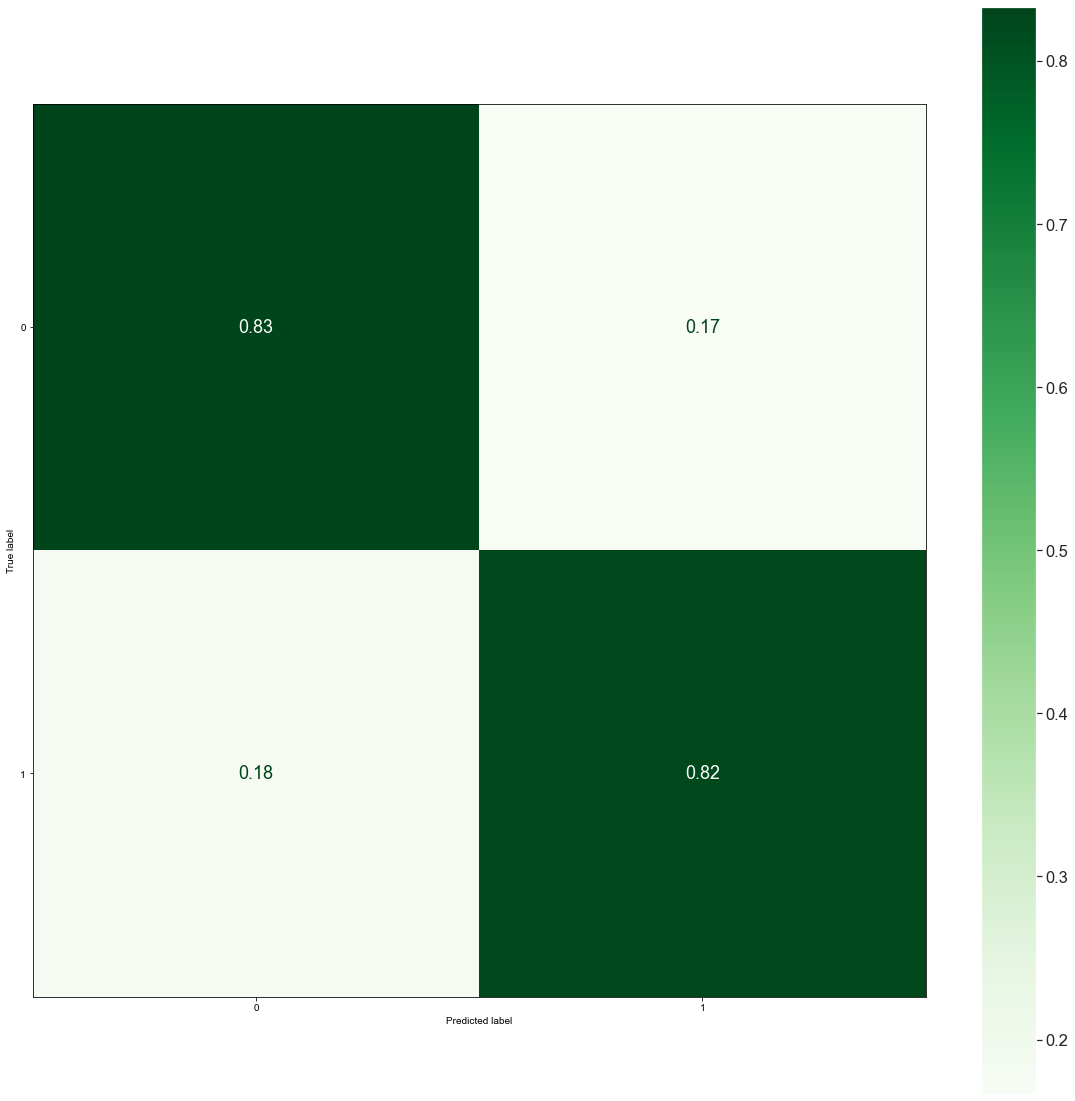

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

ml = df.copy()
X = ml.content
y = ml.target
model=LogisticRegression(max_iter=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2))
X_train_tf = tfidf.fit_transform(X_train)
model.fit(X_train_tf, y_train)
X_test_tf = tfidf.transform(X_test)
y_pred = model.predict(X_test_tf)
print('Accuracy Score - {}'.format(accuracy_score(y_test, y_pred)))
print('Recall Score (macro) - {}'.format(recall_score(y_test, y_pred,average='macro')))
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)
plot_confusion_matrix(model,X_test_tf,
                    y_test,
                    normalize='true',
                    cmap=plt.cm.Greens,
                    ax=ax)
print(fig)
print('Model Report:\n ' + classification_report(y_test, y_pred))